In [1]:
# If running on colab, uncomment the line below and run this cell:
#!pip in stall devito

# Part 3: Full-Waveform Inversion (FWI)

This notebook highlights various aspects of seismic inversion based on Devito operators. In this example we aim to illustrate the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data.

## Algorithm outline and requirements

Seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded/observed data**. This is a shot record corresponding to the true velocity model. In order to simplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

# Imaging with back-propagation

## The Objective Function

- The central purpose of FWI is to find a physical model of the wave-transmitting medium that minimises the difference between an observed dataset and the same dataset as predicted by the model. 
- A common way of doing this is to measure the $L_2-norm$ of the difference between our predicted data set `p` and the observed data set `d`.

\begin{equation}
  \phi(\mathbf{m})=\frac{1}{2}||\mathbf{p}-\mathbf{d}||^2=\frac{1}{2}||\delta\mathbf{d}||^2=\frac{1}{2}\delta\mathbf{d}^{T}\delta\mathbf{d}.
\end{equation}

- We now want to minimize this functional with respect to the model $\mathbf{m}$ (which in the acoustic example here will be $1/c^2$).

## Local Inversion

The model update we need, $\delta\mathbf{m}$, to minimize the objective function is:

\begin{equation}
  \delta\mathbf{m} \approx - \left(\frac{\partial^2 \phi}{\partial\mathbf{m}^2}\right)^{-1}\frac{\partial \phi}{\partial\mathbf{m}} \equiv -\mathbf{H}^{-1}\nabla_{\mathbf{m}}\phi.
\label{li4} \tag{23}
\end{equation}

- $\nabla_{\mathbf{m}}\phi$ is the *gradient* of the objective function $\phi$ with respect to the model parameters
- $\mathbf{H}$ is the *Hessian* matrix of second differentials, both evaluated at $\mathbf{m}_0$.

## Steepest Descent

- The Hessian is in general not practical to compute. We could, e.g., simply replace it a scalar $\alpha$, the step length, and find a suitable value for this:

\begin{equation}
  \delta\mathbf{m} = -\alpha\frac{\partial \phi}{\partial \mathbf{m}} = -\alpha\nabla_{\mathbf{m}}\phi .
  \tag{24}
\end{equation}

The method that uses this approach is called the method of *steepest descent*, and in its
simplest form it consists of the following steps:
1. start from a model $\mathbf{m}_0$,
2. evaluate the gradient of the objective function, $\nabla_{\mathbf{m}}\phi$, for the current model,
3. find the step length $\alpha$,
4. subtract $\alpha$ times the gradient from the current model to obtain a new model,
5. iterate from step 2 using the new model until the objective function is sufficiently small (or we run out of patience).

To implement this, we need a method of calculating the local gradient.

**Note:**

Simply ignoring the Hessian is a gross simplification and while it
is not normally possible to incorporate its effects fully, there are several possibilities for
approximating its effects - L-BFGS is widely used, as are conjugate gradients.

Useful links:
- **L-BFGS**: https://en.wikipedia.org/wiki/Limited-memory_BFGS
- **Conjugate gradient**: https://en.wikipedia.org/wiki/Conjugate_gradient_method

## Calculating the gradient

In principle, we could find the gradient by perturbing each of the model parameters in turn,
and calculating what happens to the objective function each time. For $n$ model parameters,
that would require $n+1$ modelling runs, and this is not computationally feasible. Fortunately
there is a faster way using a solution to the *adjoint* problem.

First, write the gradient in terms of the residual data $\delta\mathbf{d}=\mathbf{p}-\mathbf{d}$:

\begin{equation}
  \nabla_{\mathbf{m}}\phi=\frac{\partial \phi}{\partial \mathbf{m}}=\frac{\partial}{\partial \mathbf{m}}\left(\frac{1}{2}\delta\mathbf{d}^T\delta\mathbf{d}\right)=\frac{\partial (\mathbf{p}-\mathbf{d})^T}{\partial \mathbf{m}}\delta\mathbf{d}=\left(\frac{\partial \mathbf{p}}{\partial \mathbf{m}}\right)^T\delta\mathbf{d}.
  \label{eq:rw0} \tag{25}
\end{equation}

After playing around with some maths (don't worry about the details!) we end up with

\begin{equation}
  \nabla_{\mathbf{m}}\phi=-\mathbf{u}^T\left(\frac{\partial \mathbf{A}}{\partial \mathbf{m}}\right)^T(\mathbf{A^{-1}})^T\mathbf{R}^T\delta\mathbf{d}.
  \label{eq:rwe6} \tag{31}
\end{equation}

That is, to find the gradient, we must
- Calculate the forward wavefield $\mathbf{u}$
- Differentiate the numerical operator $\mathbf{A}$ with respect to the model parameters (this is an operation that we can do analytically).
- We must compute $(\mathbf{A}^{-1})^T\mathbf{R}^T\delta\mathbf{d}$.

## Interpreting the expression for the gradient

- The final term our definition of the gradient, $(\mathbf{A}^{-1})^T\mathbf{R}^T\delta\mathbf{d}$, turns out to correspond to what we call the residual wave field $\delta\mathbf{u}$.
- $\delta\mathbf{u}$ that is generated by a (virtual) source $\delta\mathbf{d}$ located at the receivers, and that is propagated by the operator $\mathbf{A}^T$ which is the *adjoint* of the operator in the original wave equation.

- For one source, the gradient calculated this way requires only two modelling runs rather
than the $n+1$ modelling runs that direct methods require.
- For multi-source datasets, the full gradient is a sum over all sources.
- In practical applications with real datasets, the wave equation will nearly always be modified in various ways to include additional physics, but this does not change the underlying approach.

## Notes on the operators

In **Part 2** we described in detail the creation of a forward modelling operator -- here we will call a wrapper function to such a model instead. This wrapper contains all necessary operators for seismic modeling, imaging and inversion. Operators introduced for the first time in this part will be properly described.

In [2]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

## Computational considerations

As we will see, FWI is extremely computationally demanding (more so than, e.g., RTM). To keep this tutorial as lightweight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [3]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

# True and smooth velocity models

We will use a very simple model domain, consisting of a circle within a 2D domain. We will again use the "true" model to generate our synthetic shot data and use a "smooth" model as our initial guess. In this case the smooth model is very smooth indeed - it is simply a constant background velocity without any features.

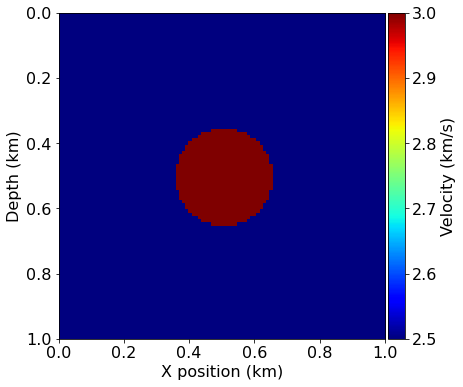

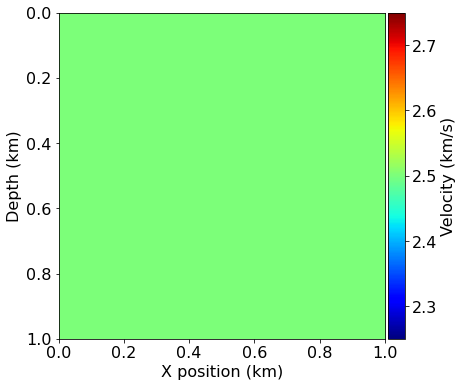

In [4]:
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                     grid = model.grid)

plot_velocity(model)
plot_velocity(model0)

## Acquisition geometry

In this tutorial, we will use the easiest case for inversion, namely a transmission experiment. The sources are located on one side of the model and the receivers on the other side. This allows to record most of the information necessary for inversion, as reflections usually lead to poor inversion results.

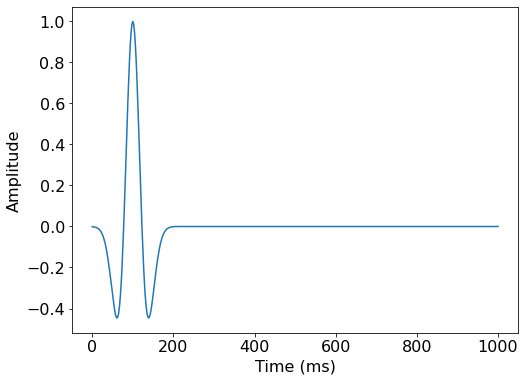

In [5]:
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

t0 = 0.
tn = 1000. 
f0 = 0.010
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 0] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

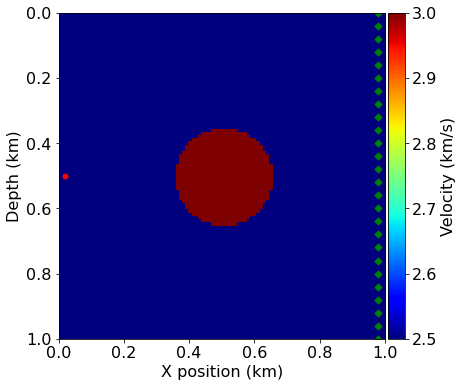

In [6]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

## True and smooth data

We can generate shot records for the true and smoothed initial velocity models, since the difference between them will again form the basis of our imaging procedure.

In [7]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)

In [8]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

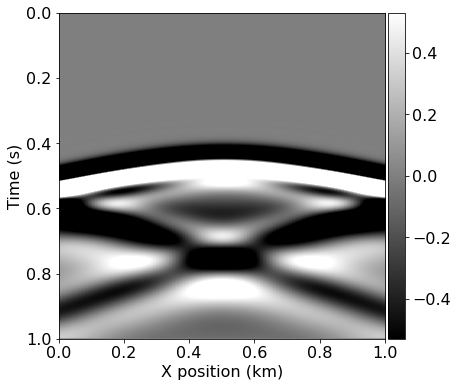

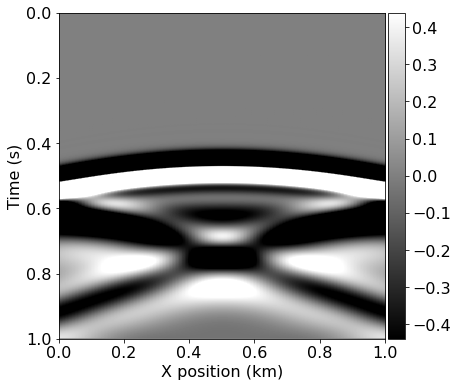

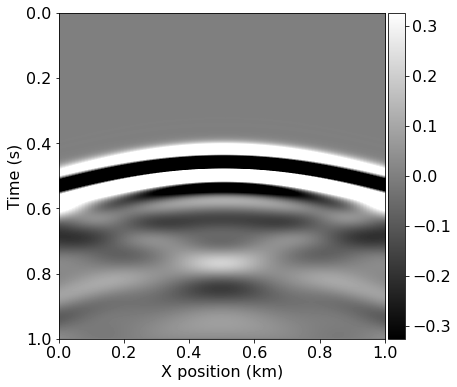

In [9]:
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

## FWI gradient operator

To compute a single gradient $\nabla\Phi_s(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to proceed as follows:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

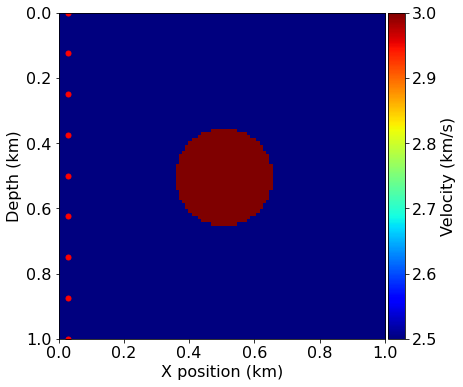

In [10]:
# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [11]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    
    return residual

In [12]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the gradient alongside the model perturbation and the effect of the gradient update on the model.

In [13]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
assert np.isclose(ff, 57283, rtol=1e0)

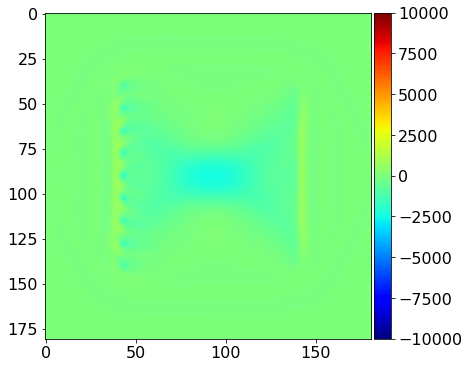

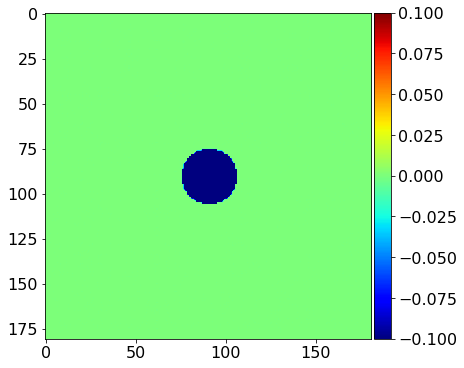

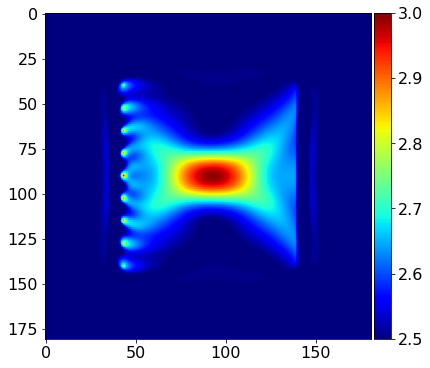

In [14]:
from devito import mmax
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

In [15]:
from sympy import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [16]:
from devito import mmax

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / mmax(direction)
    
    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 39293.264258 at iteration 1
Objective value is 24506.863315 at iteration 2
Objective value is 14386.742938 at iteration 3
Objective value is 7907.689834 at iteration 4
Objective value is 3960.135421 at iteration 5


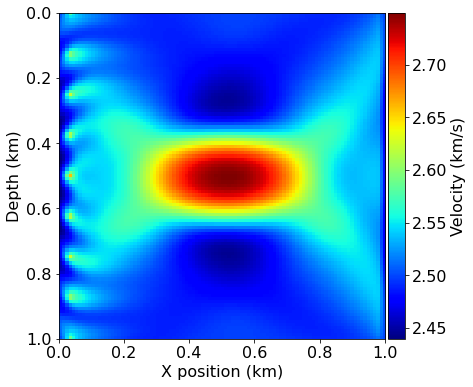

In [17]:
# Plot inverted velocity model
plot_velocity(model0)

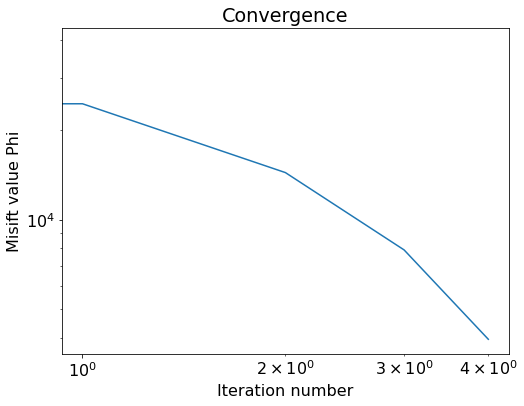

In [18]:
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## Final remarks

- For further examples and tutorials see the `examples` folder in the main Devito repository located [here](https://github.com/devitocodes/devito/tree/master/examples). Implementations of different wave-equations, PML boundary conditions, etc., can be found there.
- Out of the box, Devito can generate MPI code, GPU code (OpenMP, OpenACC, Cuda) and is compatible with ARM architectures.
- Get in touch!
    - [Website](https://www.devitoproject.org/)
    - [GitHub](https://github.com/devitocodes/devito)
    - [Slack](https://devitocodes.slack.com/ssb/redirect)